# CIC-IDS-2017 Classification using XGBoost


---

### **Abstract**  

In this notebook, I extend the work of **Οδυσσέας Κουβέλης** (refer to the original [notebook here](https://www.kaggle.com/code/nolovelost/cic-ids-2017-mlps-v-3-3/notebook)) on binary classification using the **CIC-IDS-2017** cybersecurity dataset. While the original work employed **Multilayered Perceptrons (MLPs)** to classify network traffic as benign or malicious, we explore a more efficient and interpretable approach using **XGBoost (Extreme Gradient Boosting)**, a powerful gradient boosting framework designed for structured numerical data.  

My goal is to enhance the performance of Intrusion Detection Systems (IDS) by leveraging XGBoost's ability to handle complex, high-dimensional datasets efficiently. Unlike deep learning models, XGBoost is optimized for tabular data, offering fast training, feature importance analysis, and strong generalization. In this approach, we preprocess the network traffic data, tune XGBoost hyperparameters, and evaluate its performance on the dataset.  

By applying XGBoost to cybersecurity, I contribute to the field by demonstrating its capability to recognize malicious patterns in network traffic data with high accuracy. The model's performance is assessed using key metrics such as **accuracy**, **precision**, **recall**, and **F1-score**, and compared with results from **MLPs** used in prior work. The insights gained from this study could lead to more scalable and efficient IDS implementations for real-world cybersecurity applications.  

---  



# Data Preparation

## Importing Necessary Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Natural Language Processing Libraries
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# PyTorch Libraries
import torch
from torch.utils.data import Dataset, DataLoader

# Evaluation Metrics
from sklearn.metrics import classification_report, accuracy_score


---

## Data Preprocessing


The **CIC-IDS-2017** dataset can be accessed on [Kaggle](https://www.kaggle.com/) or through the **Canadian Institute for Cybersecurity** website: [CIC-IDS-2017 Dataset](https://www.unb.ca/cic/datasets/ids-2017.html).


---

### Loading the Data

In [2]:
# Load the CIC-IDS-2017 datasets
datasets = {
    'Benign-Monday': '/kaggle/input/cicids2017/Benign-Monday-no-metadata.parquet',
    'Botnet-Friday': '/kaggle/input/cicids2017/Botnet-Friday-no-metadata.parquet',
    'Bruteforce-Tuesday': '/kaggle/input/cicids2017/Bruteforce-Tuesday-no-metadata.parquet',
    'DDoS-Friday': '/kaggle/input/cicids2017/DDoS-Friday-no-metadata.parquet',
    'DoS-Wednesday': '/kaggle/input/cicids2017/DoS-Wednesday-no-metadata.parquet',
    'Infiltration-Thursday': '/kaggle/input/cicids2017/Infiltration-Thursday-no-metadata.parquet',
    'Portscan-Friday': '/kaggle/input/cicids2017/Portscan-Friday-no-metadata.parquet',
    'WebAttacks-Thursday': '/kaggle/input/cicids2017/WebAttacks-Thursday-no-metadata.parquet'
}

# Read the datasets into DataFrames
df_data = {key: pd.read_parquet(path) for key, path in datasets.items()}


In [3]:
# Display the first 5 rows of each DataFrame
for name, df in df_data.items():
    print(f"Head of {name}:")
    # print(df.head(), "\n")


Head of Benign-Monday:
Head of Botnet-Friday:
Head of Bruteforce-Tuesday:
Head of DDoS-Friday:
Head of DoS-Wednesday:
Head of Infiltration-Thursday:
Head of Portscan-Friday:
Head of WebAttacks-Thursday:


In [4]:
# Concatenate all DataFrames into one
df_all = pd.concat(df_data.values(), ignore_index=True)

# Display the first 5 rows of the concatenated DataFrame
# print(df_all.head())


In [5]:
# Find and handle null values

# Get the count of null values in each column
null_counts = df_all.isnull().sum()

# Print the total number of null entries in the dataset
print(f"Total null entries found: {null_counts.sum()}\n")

# Drop rows with any null values
df_all.dropna(inplace=True)  

# Find and handle duplicates

# Get the count of duplicate rows
duplicate_count = df_all.duplicated().sum()

# # Print the number of duplicate entries found
print(f"Total duplicate entries found: {duplicate_count}\n")

# Remove duplicate rows from the dataset
df_all.drop_duplicates(inplace=True) 

# Inform that duplicates have been removed
print("All duplicate entries have been removed.\n")

# Reset the index after dropping rows
df_all.reset_index(drop=True, inplace=True)

# Inspect categorical columns
categorical_columns = df_all.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {categorical_columns}\n")

# Display the first 5 rows of the cleaned dataset
df_all.head(20)


Total null entries found: 0

Total duplicate entries found: 82004

All duplicate entries have been removed.

Categorical columns: ['Label']



,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,4,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,6,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
2,6,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,6,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
4,6,609,7,4,484,414,233,0,69.142860,111.967896,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
5,6,879,9,4,656,3064,313,0,72.888885,136.153809,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
6,6,1160,9,6,3134,3048,1552,0,348.222229,682.482544,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
7,6,524,7,4,2812,2820,1397,0,401.714294,679.914856,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
8,6,6,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
9,6,1119,9,6,3160,3060,1565,0,351.111115,688.214966,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


In [6]:
# Inspection of Target Feature

print('Shape of Dataframe: ',df_all.shape,'\n')
print('Inspection of Target Feature - y:\n')
# Target feature counts
print(df_all['Label'].value_counts())

Shape of Dataframe:  (2231806, 78) 

Inspection of Target Feature - y:

Label
Benign                        1895314
DoS Hulk                       172846
DDoS                           128014
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
PortScan                         1956
Web Attack � Brute Force         1470
Bot                              1437
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [7]:
# Extract features (X) and target (y)
X = df_all.drop(columns=['Label'])
y = (df_all['Label'] != 'Benign').astype(int)  # Binarize labels: 0 for 'Benign', 1 for Malicious

Class Distribution:
🟦 Benign (0): 1,895,314 samples (84.92%)
🟥 Malicious (1): 336,492 samples (15.08%)



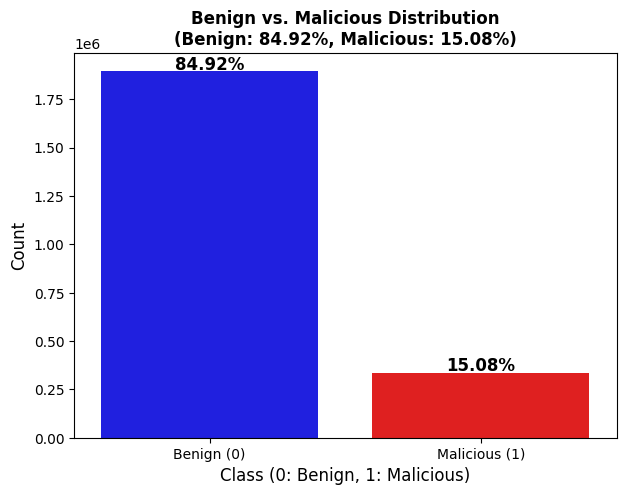

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each class
class_counts = y.value_counts()
total_samples = len(y)

# Calculate percentage of each class
benign_ratio = (class_counts[0] / total_samples) * 100
malicious_ratio = (class_counts[1] / total_samples) * 100

# Print ratios in a clean format
print(f"Class Distribution:\n"
      f"🟦 Benign (0): {class_counts[0]:,} samples ({benign_ratio:.2f}%)\n"
      f"🟥 Malicious (1): {class_counts[1]:,} samples ({malicious_ratio:.2f}%)\n")

# Plot the distribution
plt.figure(figsize=(7, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=["blue", "red"])

# Add labels and title
plt.xlabel("Class (0: Benign, 1: Malicious)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title(f"Benign vs. Malicious Distribution\n(Benign: {benign_ratio:.2f}%, Malicious: {malicious_ratio:.2f}%)",
          fontsize=12, fontweight="bold")

# Show percentage on top of bars
for i, val in enumerate(class_counts.values):
    plt.text(i, val + 10000, f"{(val/total_samples)*100:.2f}%", 
             ha='center', fontsize=12, fontweight='bold', color='black')

plt.xticks([0, 1], ["Benign (0)", "Malicious (1)"])
plt.show()


## Class Distribution and Baseline Accuracy

In this dataset, there is a notable **class imbalance**:

- **Class 0** (Majority class): **84.92%** of the samples
- **Class 1** (Minority class): **15.08%** of the samples

A simple model that always predicts the majority class (**Class 0**) would achieve a baseline accuracy of **84.92%**.

Therefore, any machine learning or deep learning model developed for this dataset must perform better than this baseline accuracy by correctly identifying instances from the minority class (**Class 1**) in order to demonstrate meaningful predictive power.


In [9]:
df_all.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,4,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,6,1,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
2,6,3,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,6,1,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
4,6,609,7,4,484,414,233,0,69.14286,111.967896,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


### Splitting the Dataset

In the typical deep learning workflow, it's essential to divide the dataset into separate subsets for **training**, **validation**, and **testing**. This division ensures that the model can be evaluated at each stage and can generalize well to new, unseen data. Here's the breakdown of each subset's purpose:

- **Training Set**: This subset is used to train the model, meaning the model learns the patterns from the data during this phase. Typically, this makes up **60-80%** of the dataset.
  
- **Validation Set**: This set is used during training to evaluate the model’s performance and tune hyperparameters (e.g., learning rate, number of epochs, etc.). It helps ensure that the model is not overfitting to the training data. This usually makes up **10-20%** of the dataset.
  
- **Test Set**: This is used to evaluate the final model after training is complete. The test set is not seen by the model during training, ensuring that it tests the model’s ability to generalize to new, unseen data. It generally comprises **10-20%** of the dataset.


### Key Points:
- **Stratified Split**: `stratify=y` ensures that the class distribution (Class 0 and Class 1) is preserved across the training, validation, and test sets. This is particularly important for imbalanced datasets.
  
- **Test Size**: Here, **20%** of the data is used for testing and validation combined, with half of that (10%) used for validation and the other half (10%) used for testing.

### Why Split the Data?

- **Training Set**: Used to fit the model. The model learns the features and patterns here.
  
- **Validation Set**: Helps monitor the model’s performance during training. If the validation performance starts to degrade while the training performance improves, it could indicate overfitting.
  
- **Test Set**: Used for final evaluation of the model’s performance after training. This ensures that the model is tested on data it hasn't seen before, providing an estimate of how it will perform in a real-world scenario.

By splitting the dataset in this manner, we ensure that the model is trained, tuned, and tested in an unbiased way.

In [10]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and temporary set (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Check the size of each set
print(f"Training Set: {X_train.shape[0]} samples")
print(f"Validation Set: {X_val.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")

Training Set: 1785444 samples
Validation Set: 223181 samples
Test Set: 223181 samples


### Data Scaling with Robust Scaler

In this notebook, I apply the **Robust Scaler** to scale the features of the **CIC-IDS-2017** dataset. The **Robust Scaler** is particularly useful when dealing with datasets that contain **outliers**, as it scales the data based on the **median** and **interquartile range (IQR)**, making it less sensitive to extreme values compared to methods like **Standardization** or **Min-Max Scaling**.

#### Why use Robust Scaler?
The **CIC-IDS-2017** dataset involves network traffic, which can contain anomalous patterns, such as **attacks** that differ significantly from regular traffic. These extreme values can skew data scaling and affect the performance of machine learning models. The **Robust Scaler** addresses this by focusing on the **median** and **IQR**, which are **robust to outliers**.

#### Formula for Robust Scaling:
The scaling transformation is calculated as follows:

$$
X_{\text{scaled}} = \frac{X - \text{median}(X)}{\text{IQR}(X)}
$$

Where:
- $X$ represents the original value of a feature,
- $\text{median}(X)$ is the median of the feature’s values,
- $ \text{IQR}(X) $ is the interquartile range, which is defined as:

$$
\text{IQR}(X) = Q3(X) - Q1(X)
$$

Where \( Q3(X) \) and \( Q1(X) \) are the 75th and 25th percentiles of the feature's values, respectively.

This transformation centers the data around zero and scales it based on the IQR, reducing the impact of outliers.


In [11]:
# Import necessary libraries
from sklearn.preprocessing import RobustScaler
import pandas as pd

def robust_scale_data(X_train, X_val, X_test):
    """
    Perform Robust Scaling on the features of the training, validation, and test datasets.

    Robust Scaling scales the data using the median and interquartile range (IQR), 
    making it less sensitive to outliers compared to other scaling methods.

    Parameters:
    - X_train (pd.DataFrame): Training dataset with original features.
    - X_val   (pd.DataFrame): Validation dataset with original features.
    - X_test  (pd.DataFrame): Test dataset with original features.

    Returns:
    - Tuple of pd.DataFrame: Scaled training, validation, and test datasets.
    """
    # Initialize the RobustScaler
    scaler = RobustScaler()

    # Fit the scaler on the training data and transform all datasets
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val_scaled   = pd.DataFrame(scaler.transform(X_val),       columns=X_val.columns)
    X_test_scaled  = pd.DataFrame(scaler.transform(X_test),      columns=X_test.columns)

    return X_train_scaled, X_val_scaled, X_test_scaled

# Apply Robust Scaling to the datasets
X_train_scaled, X_val_scaled, X_test_scaled = robust_scale_data(X_train, X_val, X_test)

# Combine scaled datasets and labels into a list for easy access
scaled_data = [X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test]

### Technical Insight: Scaling Process for Training, Validation, and Test Sets

When scaling data for machine learning models, it is crucial to handle the **training**, **validation**, and **test sets** differently to avoid **data leakage** and ensure the integrity of the model evaluation process.

#### Key Steps in the Scaling Process:
1. **Training Set**:
   - Use the `fit_transform()` method to:
     - **Fit** the scaler (e.g., compute the median and IQR for `RobustScaler`).
     - **Transform** the training data using the computed parameters.

2. **Validation and Test Sets**:
   - Use the `transform()` method to:
     - Apply the **same scaling parameters** (learned from the training set) to the validation and test data.
     - Avoid refitting the scaler on these datasets to prevent data leakage.

#### Why This Matters:
- **Data Leakage Prevention**:
  - Refitting the scaler on the validation or test sets would allow information from these datasets to influence the scaling process, leading to overly optimistic performance metrics.
- **Consistency**:
  - Applying the same scaling parameters ensures that the validation and test sets are transformed in a manner consistent with the training set, maintaining the model's ability to generalize to unseen data.
- **Model Evaluation Integrity**:
  - This practice ensures that the model's performance metrics (e.g., accuracy, F1-score) are reliable and unbiased.

#### Best Practices:
- Always fit the scaler **only on the training data**.
- Use the `transform()` method for validation and test sets to apply the learned scaling parameters.
- Avoid refitting or recomputing scaling parameters on any dataset other than the training set.

By following this approach, you ensure a robust and fair evaluation of your machine learning models while maintaining the integrity of the scaling process.

In [12]:
# Selecting Data Configuration

# Option 1: Use original data (unscaled)
# [X_train, X_val, X_test, y_train, y_val, y_test] = original_data

# Option 2: Use scaled data (preprocessed)
[X_train, X_val, X_test, y_train, y_val, y_test] = scaled_data



# **Binary Classification for Network Intrusion Detection Using XGBoost**  

This chapter focuses on the application of **binary classification** for network intrusion detection, specifically within the context of the **CIC-IDS-2017 dataset**. Binary classification, a fundamental machine learning task, involves distinguishing between two distinct classes of data. In cybersecurity, this task is crucial for differentiating between **benign** and **malicious network traffic patterns**. By leveraging binary classification within an **Intrusion Detection System (IDS)**, we can build a robust system capable of flagging suspicious network activity.  

---

### **Introducing XGBoost for Binary Classification**  

For this classification task, we employ **XGBoost (Extreme Gradient Boosting)**, a highly efficient and scalable machine learning algorithm known for its superior performance on structured datasets. XGBoost is based on the **gradient boosting framework**, where an ensemble of decision trees is built sequentially to correct errors from previous iterations, leading to a strong predictive model.  

Unlike deep learning models that require extensive feature engineering and high computational resources, XGBoost excels at handling **tabular data** with minimal preprocessing while providing **feature importance insights**. It is widely used for **high-dimensional datasets**, making it an excellent choice for cybersecurity applications like **intrusion detection**.  

---

### **Gradient Boosting and Decision Trees**  

XGBoost operates using an ensemble of **decision trees**, where each tree learns from the errors of the previous ones. The boosting process involves:  

1. **Initializing predictions** with a base value (e.g., the mean target value).  
2. **Training weak learners (decision trees)** sequentially to correct residual errors.  
3. **Optimizing the objective function** using gradient descent to minimize errors.  

Mathematically, the model is updated as follows:  

$$
F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)
$$

where:  
- $ F_m(x) $ is the updated model at iteration \( m \).  
- $ h_m(x) $ is the newly added tree.  
- $ \eta $ is the **learning rate**, controlling the contribution of each tree.  

This approach allows XGBoost to balance **bias and variance**, preventing overfitting while maintaining strong predictive performance.  

---

### **XGBoost's Key Features**  

XGBoost introduces several optimizations that make it highly effective for intrusion detection:  

1. **Regularization (L1 & L2)**: Prevents overfitting by penalizing complex trees.  
2. **Handling Missing Data**: Automatically infers the best missing value splits.  
3. **Tree Pruning**: Uses **maximum depth** instead of pre-pruning, leading to faster training.  
4. **Parallelization**: Supports multi-threaded execution for faster computation.  
5. **Feature Importance**: Identifies the most influential features for classification.  

---

### **Why Use XGBoost for Intrusion Detection?**  

1. **Efficiency & Scalability**  
   - XGBoost is optimized for large-scale datasets like CIC-IDS-2017, handling thousands of network flow samples efficiently.  

2. **Robustness Against Imbalanced Data**  
   - Cybersecurity datasets often have **imbalanced classes** (more benign traffic than malicious). XGBoost can be tuned to **assign higher weights** to underrepresented classes, improving detection accuracy.  

3. **Feature Importance Analysis**  
   - XGBoost provides **feature importance scores**, helping identify which network traffic attributes contribute most to intrusion detection.  

4. **Less Computationally Expensive than Deep Learning**  
   - While deep learning models like **BERT** require extensive GPUs/TPUs for training, XGBoost runs efficiently on standard CPUs.  

5. **Better Interpretability**  
   - Unlike deep learning models, XGBoost allows us to interpret decision paths using techniques like **SHAP (SHapley Additive Explanations)**.  

---

### **Example Workflow: Using XGBoost for IDS**  

1. **Preprocessing the Dataset**  
   - Handle missing values and standardize numerical features.  
   - Encode categorical variables (if any).  
   - Split data into **training** and **test** sets.  

2. **Model Training**  
   - Initialize an XGBoost classifier.  
   - Tune hyperparameters (**learning rate, max depth, number of trees**).  
   - Train the model using **gradient boosting**.  

3. **Model Evaluation**  
   - Evaluate using metrics like **accuracy, precision, recall, and F1-score**.  
   - Analyze **feature importance** to understand key indicators of malicious traffic.  

4. **Deployment in an Intrusion Detection System (IDS)**  
   - Deploy the trained XGBoost model to detect **real-time network intrusions**.  

---

### **Hyperparameter Tuning for XGBoost**  

Optimizing XGBoost's performance requires fine-tuning its hyperparameters:  

- **`n_estimators`**: Number of boosting rounds (trees).  
- **`max_depth`**: Maximum depth of trees (controls complexity).  
- **`learning_rate`**: Shrinks the contribution of each tree.  
- **`subsample`**: Fraction of training data used per boosting round.  
- **`colsample_bytree`**: Fraction of features used per tree.  
- **`scale_pos_weight`**: Balances imbalanced classes (higher for minority class).  

Using techniques like **Grid Search** or **Bayesian Optimization**, we can find the best parameter values for optimal performance.  

---

### **Evaluating XGBoost Performance**  

To assess the model’s effectiveness, we use key classification metrics:  

- **Accuracy**: Measures overall correctness.  
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

- **Precision**: Measures how many predicted malicious instances were correct.  
$$
\text{Precision} = \frac{TP}{TP + FP}
$$

- **Recall (Sensitivity)**: Measures the model's ability to detect all malicious instances.  
$$
\text{Recall} = \frac{TP}{TP + FN}
$$

- **F1-Score**: Harmonic mean of precision and recall (useful for imbalanced datasets).  
$$
\text{F1-score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

A well-tuned XGBoost model should exhibit **high recall** (to minimize false negatives) while maintaining a strong **F1-score**.  

---

### **Feature Importance in Intrusion Detection**  

One of XGBoost's advantages is its ability to highlight the most important features contributing to the classification decision. Using feature importance plots, we can identify **critical network traffic attributes** such as:  

- **Flow Duration**  
- **Total Forward Packets**  
- **Packet Length Variance**  
- **Idle Time Mean**  

This helps in **understanding attack patterns** and optimizing IDS rules for real-time threat detection.  

---

### **Key Considerations**  

- **Handling Class Imbalance**: Adjust `scale_pos_weight` to account for class distribution.  
- **Avoiding Overfitting**: Use regularization (`lambda`, `alpha`), early stopping, and cross-validation.  
- **Interpretable Predictions**: Apply SHAP values to explain classification results.  

---

### **Conclusion**  

By leveraging **XGBoost** for binary classification in intrusion detection, we can build an efficient, interpretable, and scalable system for identifying **malicious network activity**. Unlike deep learning models like BERT, XGBoost offers a **lightweight, high-performance solution** that is well-suited for **tabular cybersecurity data**.  

🚀 This approach provides a balance of **accuracy, efficiency, and interpretability**, making XGBoost a powerful tool for real-world **Intrusion Detection Systems (IDS)**.  

---


---

## **Initial Approach**

In the initial phase, an **XGBoost-based binary classifier** is developed and fine-tuned using the **entire dataset**. This approach involves training the model on all available data to ensure it learns the underlying patterns and relationships effectively. The performance of the classifier is then evaluated using a variety of **evaluation metrics**, such as accuracy, precision, recall, F1-score, and AUC-ROC, to assess its effectiveness in distinguishing between benign and malicious network traffic.

---

### **Key Points**
1. **Classifier Development**:
   - An **XGBoost-based binary classifier** is built to differentiate between two classes: **benign** and **malicious** network traffic.
   - The model is fine-tuned using hyperparameter optimization to achieve the best performance on the given dataset.

2. **Dataset Usage**:
   - The **entire dataset** is utilized for training and fine-tuning to ensure the model captures the full range of patterns and variations in the data.

3. **Evaluation Metrics**:
   - The classifier's performance is rigorously evaluated using multiple metrics to provide a comprehensive understanding of its effectiveness.
   - Key metrics include **accuracy, precision, recall, F1-score, and AUC-ROC**, which help in assessing the classifier's ability to detect intrusions effectively.

---

### **Why This Approach?**
- **Efficient Learning with Gradient Boosting**: XGBoost optimizes performance by sequentially improving weak learners, making it highly effective for structured datasets like network traffic data.
- **Comprehensive Learning**: Using the entire dataset allows the model to learn from all available examples, improving its generalization capabilities.
- **Feature Importance Insights**: XGBoost provides built-in feature importance analysis, helping identify key network attributes contributing to intrusion detection.
- **Thorough Evaluation**: Evaluating the model on multiple metrics ensures a robust assessment of its performance, highlighting strengths and areas for improvement.

---



In [13]:
import xgboost as xgb
import numpy as np

# Set random seed for reproducibility
seed = 314159
np.random.seed(seed)

# Define XGBoost model parameters
xgb_params = {
    "objective": "binary:logistic",  # Binary classification objective
    "eval_metric": "logloss",  # Evaluation metric for model performance
    "max_depth": 6,  # Maximum depth of trees
    "learning_rate": 0.01,  # Learning rate (eta)
    "n_estimators": 1000,  # Number of boosting rounds
    "subsample": 0.8,  # Fraction of data used per tree
    "colsample_bytree": 0.8,  # Fraction of features used per tree
    "reg_alpha": 0.1,  # L1 regularization term
    "reg_lambda": 1.0,  # L2 regularization term
    "random_state": seed,  # Random seed
    "use_label_encoder": False  # Avoid warning for label encoding
}

# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(**xgb_params)

# Inspect model parameters
print(xgb_clf.get_params())


{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 314159, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [02:20:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-logloss:0.68378	val-logloss:0.68377
[10]	train-logloss:0.59947	val-logloss:0.59942
[20]	train-logloss:0.52909	val-logloss:0.52899
[30]	train-logloss:0.46914	val-logloss:0.46899
[40]	train-logloss:0.41802	val-logloss:0.41784
[50]	train-logloss:0.37394	val-logloss:0.37373
[60]	train-logloss:0.33537	val-logloss:0.33514
[70]	train-logloss:0.30155	val-logloss:0.30131
[80]	train-logloss:0.27198	val-logloss:0.27174
[90]	train-logloss:0.24564	val-logloss:0.24539
[100]	train-logloss:0.22236	val-logloss:0.22211
[110]	train-logloss:0.20166	val-logloss:0.20140
[120]	train-logloss:0.18347	val-logloss:0.18321
[130]	train-logloss:0.16716	val-logloss:0.16689
[140]	train-logloss:0.15252	val-logloss:0.15225
[150]	train-logloss:0.13948	val-logloss:0.13919
[160]	train-logloss:0.12760	val-logloss:0.12730
[170]	train-logloss:0.11702	val-logloss:0.11671
[180]	train-logloss:0.10765	val-logloss:0.10734
[190]	train-logloss:0.09903	val-logloss:0.09871
[200]	train-logloss:0.09144	val-logloss:0.09112
[21

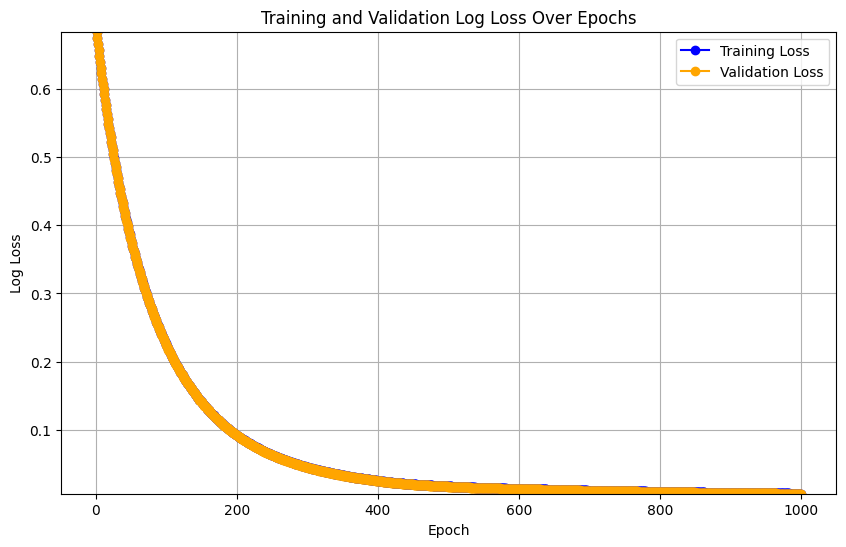

In [14]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# Set random seed for reproducibility
seed = 314159
np.random.seed(seed)

# Prepare data
# Assuming X_train, X_val, y_train, and y_val are preprocessed and ready for training
try:
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
except NameError:
    raise NameError("X_train, X_val, y_train, or y_val is not defined. Please ensure the data is loaded and preprocessed.")

# Compute class weights for handling imbalance
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
scale_pos_weight = class_weights[1] / class_weights[0]  # Adjust for imbalance

# Define XGBoost parameters
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": 6,
    "learning_rate": 0.01,
    "n_estimators": 1000,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.1,
    "reg_lambda": 1.0,
    "random_state": seed,
    "scale_pos_weight": scale_pos_weight,  # Handle class imbalance
}

# Initialize XGBoost model and capture evaluation results
evals_result = {}  # Dictionary to store evaluation results
try:
    xgb_clf = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=10,
        verbose_eval=10,
        evals_result=evals_result  # Capture evaluation results
    )
except Exception as e:
    raise RuntimeError(f"Error training XGBoost model: {e}")

# Make predictions on validation set
val_preds_prob = xgb_clf.predict(dval)
val_preds = (val_preds_prob > 0.5).astype(int)

# Compute validation metrics
val_accuracy = accuracy_score(y_val, val_preds)
val_precision = precision_score(y_val, val_preds)
val_recall = recall_score(y_val, val_preds)
val_f1 = f1_score(y_val, val_preds)
val_auc = roc_auc_score(y_val, val_preds_prob)

print("\nValidation Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1-Score: {val_f1:.4f}")
print(f"AUC-ROC: {val_auc:.4f}")

# Save the best model
xgb_clf.save_model("best_xgboost_model.json")

# Load the best model
best_xgb = xgb.Booster()
best_xgb.load_model("best_xgboost_model.json")

def plot_training_xgboost(evals_result):
    """
    Plots the training and validation loss over epochs for an XGBoost model.
    
    Parameters:
        evals_result (dict): Dictionary containing evaluation results.
    """
    # Extract training and validation logloss values
    train_logloss = evals_result['train']['logloss']
    val_logloss = evals_result['val']['logloss']

    # Create an array of epoch numbers
    epochs = range(1, len(train_logloss) + 1)

    # Create a line plot to visualize the loss over epochs
    plt.figure(figsize=(10, 6))

    # Use consistent styling for the plot
    plt.plot(epochs, train_logloss, label='Training Loss', marker='o', linestyle='-', color='blue')
    plt.plot(epochs, val_logloss, label='Validation Loss', marker='o', linestyle='-', color='orange')

    # Label the axes and add a title
    plt.xlabel('Epoch')
    plt.ylabel('Log Loss')
    plt.title('Training and Validation Log Loss Over Epochs')

    # Add a legend and grid
    plt.legend()
    plt.grid(True)

    # Automatically adjust the plot to the range of values
    plt.gca().autoscale(enable=True, axis='y', tight=True)

    # Display the plot
    plt.show()

# Create the plot
try:
    plot_training_xgboost(evals_result)
except NameError:
    raise NameError("evals_result is not defined. Ensure the XGBoost model is trained successfully.")